# Bayesian Inference: Prior and Posterior

In [1]:
# Import some helper functions (please ignore this!)
from utils import *

**Context:** If there's one thing we learned from the chapter on model selection and evaluation is that we should not blindly trust our models. Models are complicated and require a robust and diverse toolkit for responsible evaluation in their intended context. For safety-critical applications of ML, like the ones from the IHH, we must take additional precautions to ensure responsible use. We therefore adopt the following philosophy:
1. **Finite information $\rightarrow$ uncertainty.** We're often asked to make decisions without all the information necessary for certainty. We ask the same of our models: given a finite data set and an incomplete understanding of the phenomenon we're modeling, we ask models to make predictions for data they have never encountered. Therefore, for responsible use in safety-critical contexts, our models must have some way of quantifying the limits of their "knowledge."
2. **Not making choices $\rightarrow$ a choice will be made for you.** If we avoid making explicit choices in the design of our model, a choice will still be made for us---and it might not be the choice we want. For example, without explicitly choosing what's important to us, we might get a model with the highest accuracy for a task for which minimizing false negatives is most important. *It's therefore better to make your choices explicitly.* Making assumptions explicit is especially important for uncertainty quantification. 

**Challenge:** To satisfy our new modeling philosophy, we need (1) a way to quantify uncertainty, and (2) a way to understand how uncertainty depends on our modeling choices. How can we do that with the tools we have? As we show here, we can't. We will then introduce a new way of fitting ML models called Bayesian inference.

**Outline:** 
* Motivate the need for uncertainty
* Introduce a new modeling paradigm based on Bayes' rule
* Provide intuition for this modeling paradigm
* Implement this modeling paradigm in `NumPyro`
* Gain intuition how different models have different uncertainty

**Data:** To help make the concepts concrete, we'll return to our regression data, in which we wanted to predict telekinetic ability from age. Let's load the data in:

In [2]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax
import jax.numpy as jnp

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-CTR-CGLF-regression-augmented.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

,Age,Glow,Telekinetic-Ability
Patient ID,,,
90,30.607729,0.604085,-0.020933
254,38.531357,0.613645,-0.070165
283,21.879414,0.829212,0.140791
445,2.949004,0.981120,0.261027
461,30.237446,0.688329,-0.027250
15,29.562483,0.796853,-0.033701
316,15.283975,0.839546,0.344510
489,2.688488,0.929422,0.268031
159,4.129371,0.893813,0.422464


## Why We Need Uncertainty

**The MLE is Over-Confident.** In safety-critical contexts, like those from the IHH, it's important that our ML models don't just fit the observed data well; they should also communicate with us the limits of their "knowledge." Let's illustrate what we mean. Consider the regression data below:

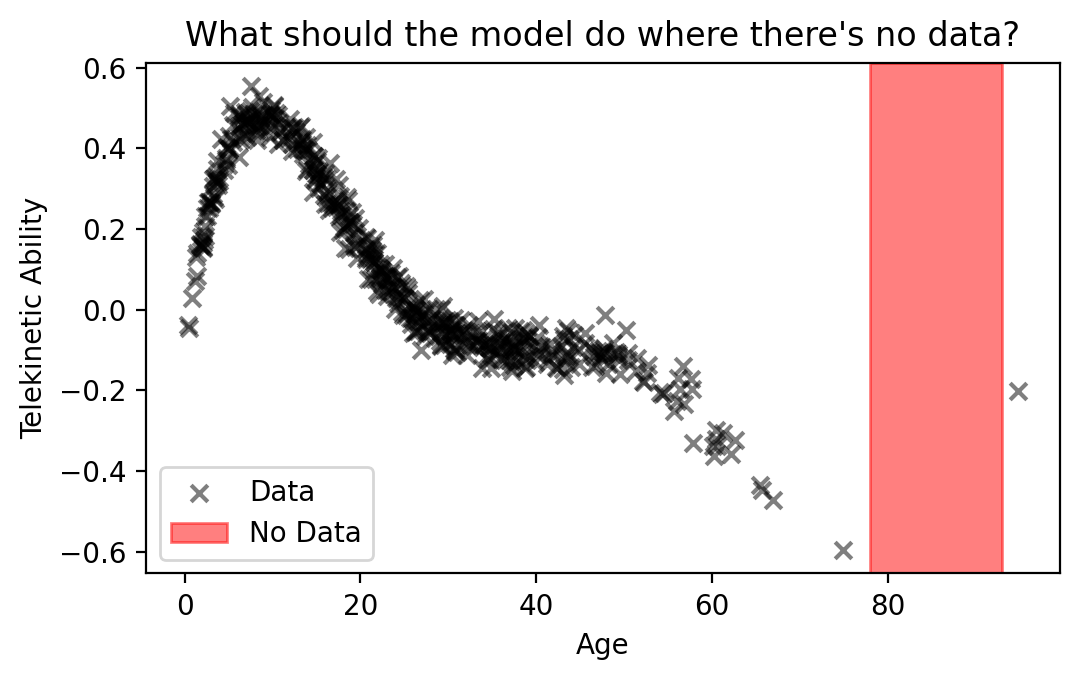

In [3]:
plt.figure(figsize=(5.5, 3.5))

plt.scatter(data['Age'], data['Telekinetic-Ability'], color='black', alpha=0.5, marker='x', label='Data')
plt.axvspan(78, 93, alpha=0.5, color='red', label='No Data')

plt.xlabel('Age')
plt.ylabel('Telekinetic Ability')
plt.title('What should the model do where there\'s no data?')
plt.legend()
plt.tight_layout()
plt.show()

If we were to make a prediction for a patient of age 85, what should the model do? The model wasn't trained on any such patients. Does the trend keep going down with age? Doing so would ignore the point at the very right of the plot, treating it as an *outlier*. Or maybe the trend should go up after age 80? It's impossible for us to know because we haven't observed data about such patients. In cases such as these, it's important that our model alert us about its uncertainty. 

Especially in recent years, there has been more and more research dedicated to developing models that can reliably quantify uncertainty. As an example, a recent paper evaluated how confident different deep learning models are on a medical imaging task. In the paper, the authors evaluated models for predicting whether patients had COVID or not from X-ray scans. Here's what they found:


```{figure} _static/figs/cats-vs-covid.png
---
width: 100%
name: cats-vs-covid
align: center
---

ML models can be over-confident about wrong predictions. Figure adapted from [this paper](https://www.semanticscholar.org/paper/Can-Your-AI-Differentiate-Cats-from-Covid-19-Sample-Mallick-Dwivedi/c100c33afbb2efa5197f7d6042022e1227c5e298).
```
As you can see from the figure, the model makes predictions that aren't only incorrect, *but also overconfident*. And it does this for inputs (like the cat) for which it should really just communicate "I don't know." 

How can a model know when it "doesn't know"? One way to do this is to alert us when many possible models fit the data reasonably well, but behave differently away from the data (i.e. on previously unseen inputs, like the cat). Unfortunately, the learning algorithm we've used so far---the MLE---doesn't provide us with a way to do this. The MLE gives a *single* model. 

**Ensembling.** If the MLE gives us a single model, why not use it to fit a whole *ensemble* of models? We could rely on the imperfections of the optimizer to give us a diversity of models. Remember that, especially for more expressive models, optimization tends to get stuck in local optima. What if we were to collect an ensemble of models, all fit with the MLE to data, but each optimized from a different random initialization? Because each model would get stuck in a different local optima, each *might* behave differently than the others away from the data. What's nice about this approach is that it's easy to implement: we already have all the tools we need! Let's see what ensembling a neural network regression model looks like:

```{figure} _static/figs/example_nn_ensemble_regression.png
---
width: 100%
name: nn_ensemble_regression
align: center
---

Ensembling 10 neural networks of different sizes.
```

As you can see, with ensembling, we managed to get a more diverse set of functions (though in this case, not all that diverse---they all have roughly the same trend). Ensembling can be quite effective in practice, but it suffers from one main shortcoming when it comes to safety-critical contexts: it makes implicit assumptions that are difficult to understand. Specifically, we relied on the imperfections of our black-box optimizer to find us a diverse set of models. What kind of models will the optimizer give us, however? Do these models have an *inductive bias* that's appropriate for our task? 

The need for explicit assumptions motivates us to find an alternative way of fitting our models, leading us to the *Bayesian approach*. 

## What is Uncertainty?

To design a system that captures uncertainty, we first need to know what it means. To do this, let's think about the uncertainty we encounter in everyday scenarios. Maybe these will help us formalize uncertainty mathematically.

**Total Certainty.** When you have lots of data, and you have a *mechanistic* understanding of the system, you have certainty. By mechanistic understand, we mean that you can characterize the system mathematically (e.g. you can predict how quickly an object will fall because you have an equation for gravity).
> Example: You're asked to predict whether the sun will rise tomorrow. Of course, you know the sun will rise tomorrow, and you're absolutely certain about it (if you have reason to believe the sun will not rise tomorrow, please do let the teaching staff know so they can head to the course bunker). So what makes you sure the sun will rise tomorrow? There are two reasons you will likely think about. (1) You have an abundance of observational data---the sun has risen every day of your life. (2) You have a model (or inductive bias)---you know that day and night are created by the earth's rotation around its axis. Because you understand the mechanical properties of the system, you know that certain predictions just don't make sense---like the sun can't rise twice in the span of 24 hours.

**Aleatoric Uncertainty.** When you have lots of data from a *noisy* system, you can be certain about the probability of an outcome, but not about the actual outcome. As an example, having observed 100 flips of a fair coin, you can say with fair certainty that the coin will land heads 50\% of the time. But you will never be able to predict whether the next flip will be heads with any greater accuracy. We call this type of uncertainty, *aleatoric uncertainty*. This is uncertainty that's due to the inherent stochasticity in the system. 
> You're asked to predict whether it will rain at Wellesley next week. Having lived in New England for a little while, you scoff at the possibility of getting this prediction correct. New England weather is notoriously unpredictable. So what makes you uncertain about our prediction? You have an abundance of experiential data suggesting that weather is difficult to predict (how many times have you stood outside in the rain, while your phone's weather app says it's sunny?). As a result, you're certain we can't make a good prediction.

All models we've worked with so far quantify aleatoric uncertainty. For example, in our regression and classification models, our observation error captures aleatoric uncertainty.  

**Epistemic Uncertainty.** When you don't have enough data, and you also don't have a mechanistic understanding of the system, you have epistemic uncertainty. In this case, we'd ideally like to have a diversity of possible models that fit the data. 
> You're colleague for the IHH is getting married on Venus next week. Your friend, who is also attending the wedding, asked you to predict the weather on Venus next week (so you can choose your outfit). Having forgotten all of your astrophysics knowledge (or having never learned it), you actually don't know what the weather on Venus is like in general. As a result, what makes you uncertain is: (1) a lack of observations or experiential knowledge, and (2) a model (or domain knowledge) about Venus's climate.

None of our models so far have been able to capture epistemic uncertainty. In the regression case, epistemic uncertainty would be uncertainty over the *parameters* of the model. Epistemic uncertainty indicates that many potential models could explain the observed data, but we don't know which one is the "right" one. We can reduce our uncertainty by observing more data.

**Visualizing Regions of Uncertainty.** Returning to our original data of Telekinetic Ability vs. Age, we see that:
* Where we've observed data, there's *aleatoric uncertainty*: there's "noise" around the trend. No matter how good your model is, it will only be able to predict the trend, not the noise around it.
* Where we haven't observed data, there's *epistemic uncertainty*: we don't know what's the appropriate model behavior. In addition to epistemic uncertainty, there's still aleatoric uncertainty. 

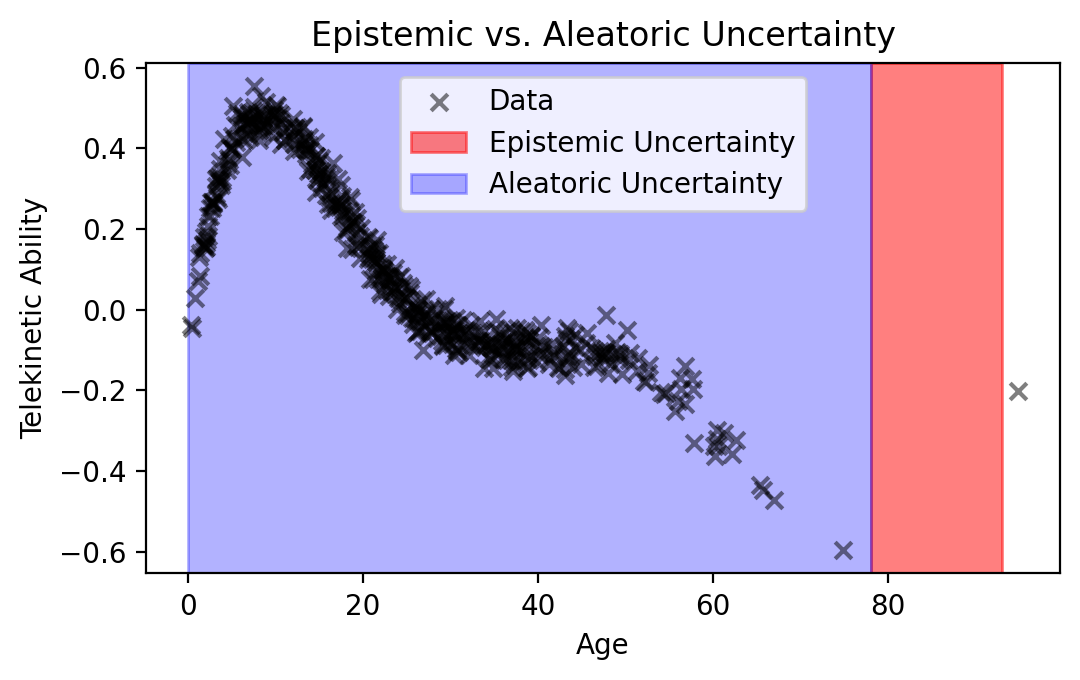

In [4]:
plt.figure(figsize=(5.5, 3.5))

plt.scatter(data['Age'], data['Telekinetic-Ability'], color='black', alpha=0.5, marker='x', label='Data')
plt.axvspan(78, 93, alpha=0.5, color='red', label='Epistemic Uncertainty', zorder=-10)
plt.axvspan(0, 78, alpha=0.3, color='blue', label='Aleatoric Uncertainty', zorder=-10)

plt.xlabel('Age')
plt.ylabel('Telekinetic Ability')
plt.title('Epistemic vs. Aleatoric Uncertainty')
plt.legend()
plt.tight_layout()
plt.show()

**Conclusion.** We need some way of capturing epistemic uncertainty. To do this, we'll next introduce a different way of fitting models, called *Bayesian inference*. 

````{admonition} Exercise: Identify Type of Uncertainty
In each of the scenarios below, identify the sources of uncertainty (i.e. why you can't be certain about the outcome---be creative!), and categorize them into aleatoric vs. epistemic. Explain your reasoning.
1. A new tree was planted outside your window. You want to predict how tall it will be in one year. 
2. You want to predict your grade on your next CS exam.
3. You want to predict your own mood tomorrow. 
4. You just met someone at a party. You want to predict their mood tomorrow.
````

## The Bayesian Modeling Paradigm

**Capturing Epistemic Uncertainty.** So let's go back to the drawing board and rethink how we've been fitting models this whole time. So far, our approach has been finding the *single* model that maximizes the probability of our observed data: $\theta^\text{MLE} = \log p(\mathcal{D}; \theta)$. But isn't what we're actually interested is the *distribution* of models given the data, $p(\theta | \mathcal{D})$? In other words, conditioned on the data we've observed so far, we want to know which models (represented by their parameters, $\theta$) are likely to fit the data well. In this new paradigm, we hope that:
1. $p(\theta | \mathcal{D})$ will capture a diversity of models with different inductive biases.
2. We can make our assumptions clear, and we can specify what type of inductive biases are appropriate for our task.

And assuming we could compute this distribution, $p(\theta | \mathcal{D})$, how would we actually use it for fitting a model? The process goes something like this:
1. **Prior:** Prior to having observed data, we express our beliefs about possible sets of parameters, $\theta$. Our beliefs don't have to be correct, just reasonable. We then encode our beliefs into a distribution, $p_\theta(\cdot)$, called the "prior."  For example, we scientifically believe that as age increases, glow decreases. As such, we force the slope to be negative by setting $p_\theta(\cdot)$ to be a Normal distribution centered at some negative number. 
2. **Likelihood:** Having observed data, we can score how well any set of parameters, $\theta$, from the prior fits the data by evaluating $p(\mathcal{D} | \theta)$, the joint data likelihood. This distribution is the *very same* distribution we've worked with in all previous chapters.
3. **Posterior Update:** Post observing data, we *update* our beliefs about $\theta$. We do this by computing $p(\theta | \mathcal{D})$. Observing data will help us reduce the initial uncertainty from the prior, honing in on a set of parameters that could explain the data well. As we show in a bit, this posterior update will depend on both the prior and the likelihood distributions. 

**Bayesian Models.** By having a prior distribution $\theta$ to encode our beliefs, we now treat $\theta$ as a *random variable*. This means that our generative process will now include an additional line, in which we sample $\theta$ from the prior. For example, for Bayesian regression, our generative process is:
\begin{align}
\theta &\sim p_\theta(\cdot) \quad (\text{prior}) \\
y_n | x_n, \theta &\sim p_{Y | X}(\cdot | x_n, \theta) = \mathcal{N}(\mu(x_n; \theta), \sigma^2) \quad (\text{likelihood}) \\
\end{align}

We can similarly depict our Bayesian model using a directed graphical model as follows:
<div class="canva-centered-embedding">
  <div class="canva-iframe-container">
    <iframe loading="lazy" class="canva-iframe" src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGLCabxKck&#x2F;QEOGc0tkynDEzLYyuE3z9w&#x2F;view?embed">
    </iframe>
  </div>
</div>

As you can see, the difference between the depiction of the non-Bayesian and the Bayesian regression is that $\theta$ is in a circle, indicating its a random variable. Next, the circle is *white* (not filled in), indicating that $\theta$ is not observed. Our goal will be to infer it given the data. 

Before defining $p(\theta | \mathcal{D})$, let's walk through an example to show you what this process looks like.

**Illustration: Bayesian Regression.** Let's see what the Bayesian modeling paradigm looks like for regression, visually. We'll use the generative process from above, setting $\sigma$ as a constant (so we can ignore it). We've picked an expressive function, $\mu(x_n; \theta)$, that will be fun to visualize---its details aren't important. 

Given our generative process, our goal is to sample the posterior,
\begin{align}
p(\theta | \mathcal{D}) &= p(\theta | x_1, \dots, x_N, y_1, \dots, y_n).
\end{align}
For intuition, we can visualize posterior samples $\theta \sim p(\theta | \mathcal{D})$ by plotting the *functions* they represent, $\mu(x_n; \theta)$. The plot below shows samples from the posterior as the number of points, $N$, increases. 

```{figure} _static/figs/example_online_bayesian_regression.png
---
width: 100%
name: bayesian-update-example
align: center
---

Samples from the posterior of a Bayesian regression model, capturing epistemic uncertainty.
```

In the above plot, $N = 0$ represents our *prior*. The functions drawn from our prior illustrate our beliefs about which functions are appropriate for the data. In this specific case, our prior functions don't exhibit any strong trends; overall, the functions don't increase/decrease as age increases---they just wiggle about. However, the functions are incredibly smooth---another prior may have drawn more jagged functions. Whether this prior is appropriate for our task is up to you to decide. 

Next, we see what happens as we start observing data. As $N$ increases, you can see our prior distribution getting "filtered out" by the likelihood. By this, we mean that our posterior will sample functions that are both likely under the prior *and* likelihood. It therefore keeps samples from the prior that also go *through the data* to ensure the likelihood is high. As you can see, in regions of the input space near our observed data, the posterior is quite certain about the trend; it knows the function must pass close to the observed data. But as we move away from the observed data, the posterior maintains a diversity of possible functions. 

## Model-Fitting via Bayes' Rule

**Bayes' Rule.** But what is $p(\theta | \mathcal{D})$, exactly? How can we possibly write down a distribution of models that fit the data well by hand? To avoid specifying this distribution by hand, we will use *Baye's rule* to write down $p(\theta | \mathcal{D})$ in terms of what we already know how to specify: the joint data likelihood, $p(\mathcal{D} | \theta)$. and the prior. 

Let's derive Bayes' rule in general before applying it to our problem. Recall from the chapter on joint probability that a joint distribution over two random variables, $A$ and $B$, can be factorized as follows:
\begin{align}
p_{A, B}(a, b) &= p_{B | A}(b | a) \cdot p_A(a) \quad (\text{Option 1}) \\
&= p_{A | B}(a | b) \cdot p_B(b) \quad (\text{Option 2})
\end{align}
This means we can also equate the two factorizations:
\begin{align}
p_{B | A}(b | a) \cdot p_A(a) &= p_{A | B}(a | b) \cdot p_B(b)
\end{align}
Diving both sides by $p_A(a)$, we get:
\begin{align}
p_{B | A}(b | a) &= \frac{p_{A | B}(a | b) \cdot p_B(b)}{p_A(a)} \quad \text{(Bayes' Rule)}
\end{align}
This is Bayes' rule. What's cool about it is that relates $p_{B | A}(b | a)$ to $p_{A | B}(a | b)$. 

**Bayesian Inference.** Using Bayes' rule in the context of our problem, let's treat $\mathcal{D}$ *and* $\theta$ as random variables. We can now relate $p(\theta | \mathcal{D})$, which we don't know how to specify, to $p(\mathcal{D} | \theta)$, which we do know how to specify:
\begin{align}
\underbrace{p(\theta | \mathcal{D})}_{\text{posterior}} &= \frac{\overbrace{p(\mathcal{D} | \theta)}^{\text{likelihood}} \cdot \overbrace{p(\theta)}^{\text{prior}}}{\underbrace{p(\mathcal{D})}_{\text{normalizing const.}}}
\end{align}
When used as a model-fitting paradigm, each term in Bayes' rule has a special name. We'll now define each:
* **Likelihood:** This is the data joint likelihood, which we've previously maximized as part of the MLE.
    > For example, suppose we're fitting a linear regression model to predict an intergalactic being's glow given age. Our model is then:
    > \begin{align}
    p(\mathcal{D} | \theta) &= \prod\limits_{n=1}^N p(\mathcal{D}_n | \theta) \\
    &= \prod\limits_{n=1}^N p_{Y | X}(y_n | x_n, \theta) \\
    &= \prod\limits_{n=1}^N \mathcal{N}(y_n | \underbrace{\theta_0 + \theta_1 \cdot x_n}_{\mu(x_n; \theta)}, \sigma^2)
    \end{align}
    > where $\theta = \{ \theta_0, \theta_1 \}$ is the slope and intercept, and $\sigma$ is observation noise variance (which we fix as a constant for now). 
* **Prior:** This is the distribution of models we're willing to consider *before having observed any data*. The prior allows us to specify our model's *inductive bias*.
    > Continuing with the above example, we know that in general, glow decreases with age. We can encode this belief into the inductive bias of the model by selecting an appropriate prior distribution---one for which the slope, $\theta_1$, is likely negative. As an example, we could select, $\mathcal{N}(-1, 0.1)$. In this way, $\theta_1$ is most likely to be near $-1$. We can similarly encode our belief into the intercept, $\theta_0$, saying we believe it should be positive: $\mathcal{N}(1, 0.1)$. 
    > Putting these together, we get the following prior distribution over our model parameters:
    > \begin{align}
    p_\theta(\cdot) = p_{\theta_1}(\cdot) \cdot p_{\theta_0}(\cdot) = \mathcal{N}(-1, 0.1) \cdot \mathcal{N}(1, 0.1)
    \end{align}
    In contrast to the ensembling approach, prior specification makes our assumptions about uncertainty explicit and easier to interrogate. 
* **Posterior:** This is the distribution of interest. It's called a posterior because it determines the distribution of likely models, $\theta$, *after having observed data*. The posterior balances information from both the prior and the likelihood. 
* **Normalizing Constant:** This is a constant that turns the whole fraction into a valid probability density function (i.e. a function that integrates to 1). To compute $p(\mathcal{D})$, we use the law of total probability:
    \begin{align}
    p(\mathcal{D}) &= \int\limits \underbrace{p(\mathcal{D} | \theta) \cdot p(\theta)}_{\text{numerator of Bayes' rule}} d\theta
    \end{align}
    Notice that the law of total probability tells us to integrate the numerator of Bayes' rule over the support of $\theta$. In doing so, when we divide by it, the whole fraction integrates to $1$. In general, marginalizing out a variable via the law of total probability is intractable---there's no analytic solution to it, and approximating it is computationally too expensive. For now, we won't worry about how to compute this integral (or how to *avoid* computing it).

**Computational Efficiency.** Unfortunately for us, for most models, Bayesian inference is *intractable*, meaning there exists no efficient algorithm for posterior sampling. As a result, we will have to resort to approximations. This is the main drawback of Bayesian inference. Approximate Bayesian inference is fascinating, but unfortunately, we will not get to study it here. We will, however, learn how to use some approximate inference algorithms. 

## Bayesian Models in `NumPyro`

**The Model.** As you may have expected, writing out explicitly all parts of the model in math will now allow us to translate into `NumPyro`. And using some wizardry, `NumPyro` will do the heavy lifting for us, sampling from the model's posterior.

The process of describing a Bayesian in `NumPyro` will actually not differ much from the process of writing its coding its non-Bayesian counterpart. We'll therefore start with the non-Bayesian version using the syntax you're already familiar with, and then we'll show you how to make it Bayesian. 

**Review: Non-Bayesian Linear Regression.** For the specific model we'll implement, we'll use a univariate linear regression model. Here's the non-Bayesian version.

In [5]:
def univariate_linear_regression(N, x, y=None):
    slope = numpyro.param(
        'slope',
        jnp.array([-1.0]),
        constraint=C.real,
    )

    intercept = numpyro.param(
        'intercept',
        jnp.array([1.0]),
        constraint=C.real,
    )

    std_dev = numpyro.param(
        'std_dev',
        jnp.array(1.0),
        constraint=C.positive,
    )

    with numpyro.plate('data', N):
        mu = numpyro.deterministic('mu', slope * x + intercept)
        p_y_given_x = D.Normal(mu, std_dev)
        numpyro.sample('y', p_y_given_x, obs=y)

In the above model, there's only one primitive we haven't covered yet: `numpyro.deterministic`. Notice how `cs349_sample_generative_process` returns variables created with `numpyro.param` and `numpyro.sample`? This new primitive, `numpyro.deterministic`, allows you to save all other variables. In this case, since we're interested in visualizing *epistemic uncertainty*, we want to visualize $\mu(\cdot; \theta)$. This new primitive allows us to save it. When calling `cs349_sample_generative_process`, we'll now be able to see a new variable called `mu`.

For completeness, let's also fit the non-Bayesian model using the MLE to our IHH data:

In [6]:
NUM_ITERATIONS = 10000

# Define an optimizer; here we chose the "Adam" algorithm
optimizer = numpyro.optim.Adam(step_size=0.01)

# Pick a random generator seed for the optimizer
key_optimizer = jrandom.PRNGKey(seed=0)

# Fit the model via the MLE
result = cs349_mle(
    univariate_linear_regression, 
    optimizer, 
    key_optimizer, 
    NUM_ITERATIONS,
    len(data), 
    jnp.array(data['Age']), 
    y=jnp.array(data['Telekinetic-Ability']),
)

100%|█| 10000/10000 [00:01<00:00, 5352.39it/s, init loss: 210237.3728, avg. loss [9501-1


Done.


Using the fitted model, we can make predictions as follows:

In [7]:
# Make predictions for a set of test inputs
x_test = jnp.linspace(0.0, 100.0, 100)

# Make predictions
samples = cs349_sample_generative_process(
    result.model_mle, 
    jrandom.PRNGKey(seed=0), 
    len(x_test), 
    x_test,
)

y_pred = samples['mu']

Notice how `samples` now contains `mu`, saved from `numpyro.deterministic`.

Finally, let's plot its loss and trend against the data.

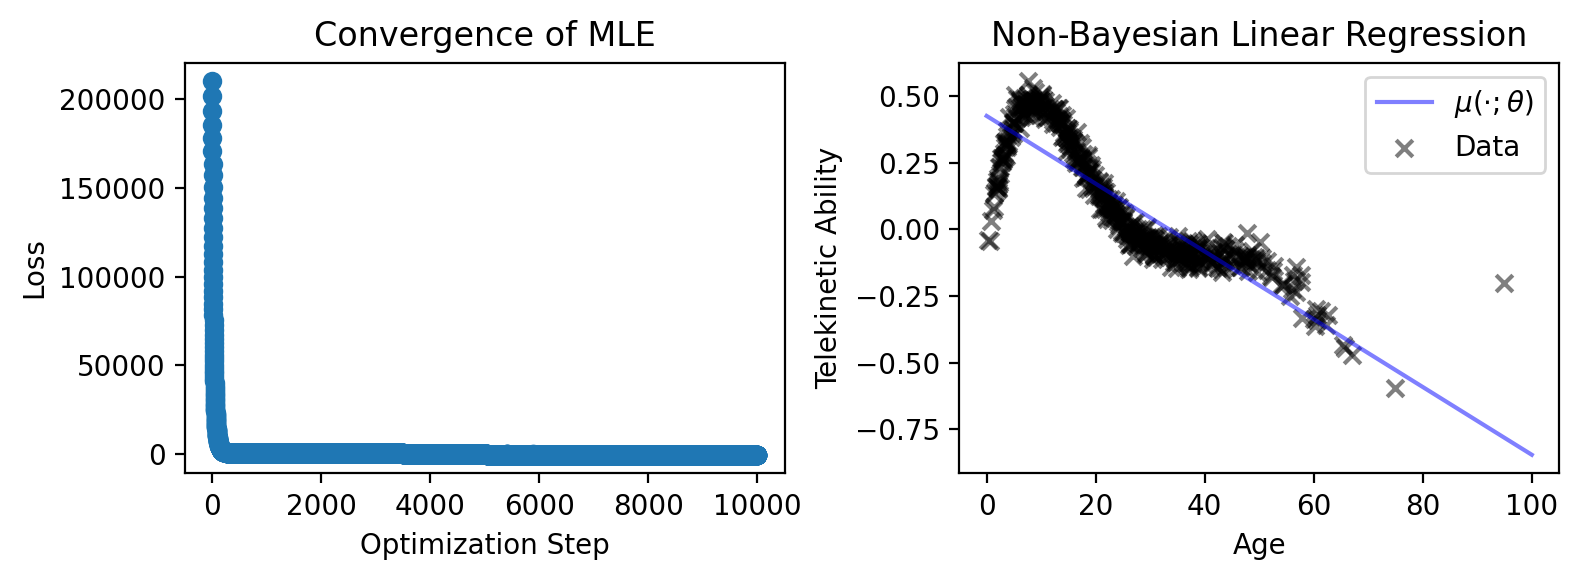

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot the loss
axes[0].scatter(jnp.arange(NUM_ITERATIONS), result.losses)
axes[0].set_xlabel('Optimization Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Convergence of MLE')

# Plot the trend of the regression
axes[1].plot(
    x_test, 
    y_pred, 
    color='blue', 
    alpha=0.5,
    label=r'$\mu(\cdot; \theta)$',
)

# Plot the data
axes[1].scatter(
    data['Age'], data['Telekinetic-Ability'], 
    color='black', marker='x', alpha=0.5, label='Data',
)

axes[1].set_xlabel('Age')
axes[1].set_ylabel('Telekinetic Ability')
axes[1].set_title('Non-Bayesian Linear Regression')

plt.legend()
plt.tight_layout()
plt.show()

As you can see, our gradient optimizer converged, and our model fits the data as well as any linear model can fit a non-linear trend.

**Bayesian Linear Regression.** The main difference between the non-Bayesian and the Bayesian versions of the model is that we no longer have fixed parameters. Our parameters are now random variables with distributions (or priors). As such, instead of using the primitive `numpyro.param`, we will use `numpyro.sample`. For example, instead of describing `slope` as follows:
```
slope = numpyro.param(
    'slope',
    jnp.array([-1.0]),
    constraint=C.real,
)
```
we instead write:
```
p_slope = D.Normal(-1.0, 0.1)
slope = numpyro.sample('slope', p_slope)
```
In this example, we specified that the prior distribution for `slope` is a Gaussian, centered at $-1.0$. Lastly, notice that, unlike in `numpyro.sample('y', p_y_given_x, obs=y)`,  when sampling the slope we *do not* pass in `obs=`. This is because we have not *observed* slope in the data---this tells `NumPyro` we'd like to *inter* it.

Replacing all fixed parameters with random variables yields the following model:

In [9]:
def univariate_bayesian_linear_regression(N, x, y=None):
    # Prior for the slope
    p_slope = D.Normal(-1.0, 0.1)
    slope = numpyro.sample('slope', p_slope)

    # Prior for the intercept
    p_intercept = D.Normal(-1.0, 0.1)
    intercept = numpyro.sample('intercept', p_intercept)

    # Inverse gamma is a standard prior for the observation noise variance
    # To get the standard deviation, we just take the square-root
    p_var = D.InverseGamma(3.0, rate=0.5)
    var = numpyro.sample('var', p_var)
    std_dev = jnp.sqrt(var)

    # Same as in the non-Bayesian version
    with numpyro.plate('data', N):
        mu = numpyro.deterministic('mu', slope * x + intercept)
        p_y_given_x = D.Normal(mu, std_dev)
        numpyro.sample('y', p_y_given_x, obs=y)

## Bayesian Inference in `NumPyro`

**Posterior Sampling.** Now that we have our Bayesian model, let's fit it by sampling from the posterior. We will do this using a helper function we've created, `cs349_bayesian_inference`. This function uses a class of algorithm called *Markov Chain Monte Carlo* (MCMC). We will not get into how such algorithms work, but there are a few things you should know about them:
1. They are iterative.
2. Given an infinite number of iterations, they will eventually draw samples from the model's posterior.
3. Since we cannot run them for an infinite number of iterations, we have to take a few precautions. First, it takes MCMC a while to start drawing samples from the posterior. As a result, we toss out the first batch of samples drawn in what's called a "warmup" phase. Second, there are some diagnostics you can run to assess the quality of the samples. 

Our helper function takes in the following arguments:
* A Bayesian `NumPyro` model.
* A random generator key, used by the inference algorithm.
* The number of warmup steps we'd like the algorithm to run for. To ensure your model converges, you should make this number as large as you can tolerate! 
* The number of samples to draw (after the warmup phase). 
* Finally, we pass in the arguments of the model. 

Putting all of this together, we get:

In [30]:
posterior_samples = cs349_bayesian_inference(
    univariate_bayesian_linear_regression, 
    jrandom.PRNGKey(seed=0), 
    20000, 
    5000, 
    len(data), 
    jnp.array(data['Age']), 
    y=jnp.array(data['Telekinetic-Ability']),
)

sample: 100%|█| 25000/25000 [00:06<00:00, 3832.98it/s, 7 steps of size 2.11e-01. acc. pr


Our helper function returns a dictionary, `posterior_samples`, the posterior samples. Have a look:

In [31]:
for k, v in posterior_samples.items():
    print('"{}" has shape = {}'.format(k, v.shape))

"intercept" has shape = (5000,)
"mu" has shape = (5000, 500)
"slope" has shape = (5000,)
"var" has shape = (5000,)


As you can see, the $0$th dimension of all of the shapes is the number of samples drawn. 

**Visualizing the Posterior.** Since we have such a small number of parameters---the slope, intercept, and observation noise variance---let's visualize their posterior distributions. Specifically, let's visualize the joint distribution of the slope and intercept (darker means higher probability):

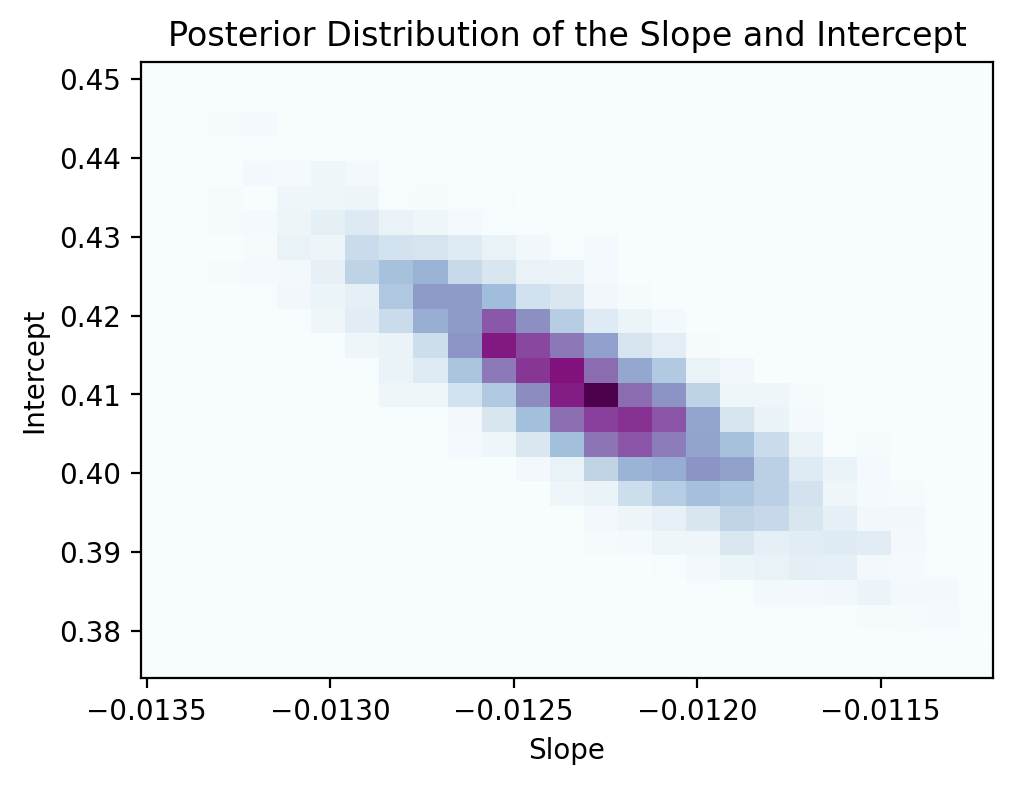

In [50]:
fig = plt.figure(figsize=(5.5, 4))
plt.hist2d(
    posterior_samples['slope'], posterior_samples['intercept'], 
    bins=25, density=True, cmap='BuPu',
)
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.title('Posterior Distribution of the Slope and Intercept')
plt.show()

Looking at the above distribution, you can see that the slope and intercept are *negatively correlated*; as slope increases, the intercept decreases. But in the prior, we sampled the slope and intercept from two *independent* Gaussians---how come they are correlated in the posterior? This is because once we observe data, we the posterior hones in on models that fit the data well. As a result, if the slope increases, the intercept has to decrease to maintain good fit (and vice versa). 

**Predicting from Posterior Samples.** Looking at `posterior_samples`, notice that the shape of `mu` is the number of samples by number of training points. However, we would like to make predictions for non-training points. How can we do that? Using another helper function we've created: `cs349_sample_predictive`. This function takes in:
* The `NumPyro` model.
* A random generator key.
* The posterior samples, returned from `cs349_bayesian_inference`.
* Arguments needed for the model. In this case, the arguments are the test points.

The functions will then apply posterior samples to the new test inputs, giving us a collection of `mu`s. 

In [33]:
predictive_samples = cs349_sample_predictive(
    univariate_bayesian_linear_regression, 
    jrandom.PRNGKey(seed=0),
    posterior_samples,
    len(x_test),
    x_test,
)

for k, v in predictive_samples.items():
    print('"{}" has shape = {}'.format(k, v.shape))

"mu" has shape = (5000, 100)
"y" has shape = (5000, 100)


Now, we can go ahead and visualize our samples of `mu`:

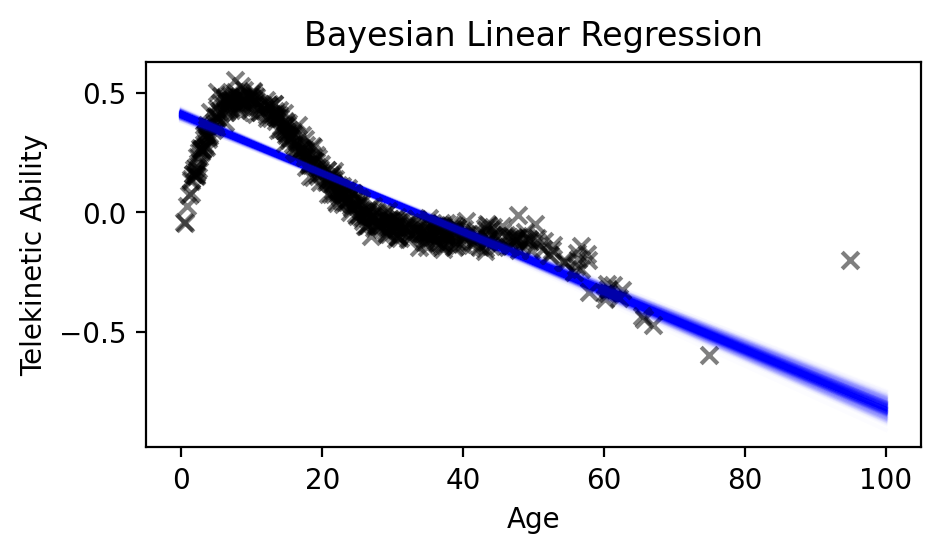

In [51]:
fig = plt.figure(figsize=(5, 2.5))

x_test = jnp.linspace(0.0, 100.0, 100)

# Iterate over posterior samples and plot them
# We'll only plot 500 samples so as not to overwhelm 
for mu in predictive_samples['mu'][-500:]:
    plt.plot(
        x_test, 
        mu, 
        color='blue', 
        alpha=0.01,
    )

# Plot the training data
plt.scatter(
    data['Age'], data['Telekinetic-Ability'], 
    color='black', marker='x', alpha=0.5, 
)

plt.xlabel('Age')
plt.ylabel('Telekinetic Ability')
plt.title('Bayesian Linear Regression')
plt.show()

As you can see from the figure, we have a distribution over different linear functions that fit our data best. Of course, none of them are particularly good, since the model is non-linear. But in the region where we have less data (age $> 80$), the model is more uncertain. 

## Comparing Bayesian Regression Models

````{admonition} Exercise: Compare Posteriors of Different Bayesian Regression Models
**Part 1:** Implement a Bayesian polynomial regression model. Please use your previous implementations of the non-Bayesian versions of these models as your starting point. Use a standard Gaussian, $\mathcal{N}(0, 1)$, for the prior over all parameters. 

**Part 2:** Implement a Bayesian neural network. Please use your previous implementations of the non-Bayesian versions of these models as your starting point. Use a standard Gaussian, $\mathcal{N}(0, 1)$, for the prior over all parameters. (For this exercise, please do not use `neural_network_fn`, which provided only for the chapter on Factor Analysis). 

**Part 3:** Given the IHH data above, perform inference on the following models:
* Bayesian linear regression (implemented above)
* Bayesian polynomial regression of degree 5
* Bayesian polynomial regression of degree 6
* Bayesian neural network regression with 1 layer and 10 hidden nodes
* Bayesian neural network regression with 1 layer and 50 hidden nodes

**Part 4:** Plot their epistemic uncertainty (i.e. the distribution of `mu`). 

**Part 5:** How does each of their epistemic uncertainty differ?

**Part 6:** For every model, change the standard deviation of the prior. What happens to the epistemic uncertainty as you increase/decrease the standard deviation of the prior?
````